<a href="https://colab.research.google.com/github/TheS1n233/Project3-Automatic-Subgroup-Identifcation-andMitigation-of-Biases-of-ML-Models/blob/main/P3_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!pip install fairlearn
!pip install captum


**1.Setup and Imports**

In [124]:
import os
import random
import numpy as np
import pandas as pd
import zipfile
import tarfile
import json
from PIL import Image
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame
from tqdm.auto import tqdm
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [125]:
zip_path = '/content/drive/MyDrive/waterbirds_v1.0-20250623T155043Z-1-001.zip'
extract_dir = '/content/waterbirds_v1.0'

if not os.path.exists(extract_dir):
    print("Extracting dataset zip to /content...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content')
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [126]:
def set_seed(seed=77):   # tried seed = {42, 77. 123}
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
image_root = '/content/waterbirds_v1.0'
csv_path   = '/content/waterbirds_v1.0/metadata.csv'
df_meta    = pd.read_csv(csv_path)
df_meta['group_id'] = df_meta['y']*2 + df_meta['place']

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.Dataset and Subgroup Labels**

In [128]:
class WaterbirdsDataset(Dataset):
    """
    用于 baseline 训练/验证/测试 —— 只返回 (image, label, subgroup_id)
    """
    def __init__(self, df, image_root, transform=None):
        self.df         = df.reset_index(drop=True)
        self.image_root = image_root
        self.transform  = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row     = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, row['img_filename'])
        image    = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        label     = row['y']
        subgroup  = row['subgroup_id']
        return image, label, subgroup


class WaterbirdsDS(Dataset):
    """
    用于方案 2（Div-Aware Reweighting）—— 额外返回样本权重 weight
    """
    def __init__(self, df, image_root, div_dict, transform=None):
        self.df         = df.reset_index(drop=True)
        self.image_root = image_root
        self.div_dict   = div_dict          # {subgroup_id : weight}
        self.transform  = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row     = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, row['img_filename'])
        image    = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        label    = row['y']
        subgroup = row['subgroup_id']
        weight   = self.div_dict.get(str(subgroup), 1.0)
        return image, label, weight


# **3.DataLoader + Transforms**

In [129]:
def load_waterbirds_splits(csv_path):
    df = pd.read_csv(csv_path)
    #  subgroup_id = y * 2 + place (0~3)
    df['subgroup_id'] = df['y'] * 2 + df['place']
    train_df = df[df['split'] == 0].copy()
    val_df   = df[df['split'] == 1].copy()
    test_df  = df[df['split'] == 2].copy()
    print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')
    return train_df, val_df, test_df

# Data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# DataLoader
train_df, val_df, test_df = load_waterbirds_splits(csv_path)

BATCH_SIZE   = 64
NUM_WORKERS  = 4
PIN_MEMORY   = True

train_loader = DataLoader(WaterbirdsDataset(train_df, image_root, transform_train),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=True)

eval_loader  = DataLoader(WaterbirdsDataset(val_df,  image_root, transform_eval),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=True)

test_loader  = DataLoader(WaterbirdsDataset(test_df, image_root, transform_eval),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=True)


Train: 4795, Val: 1199, Test: 5794


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**4.Model: ResNet-18**

In [130]:
def get_model():
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(device)


def train_epoch(model, loader, opt, criterion):
    model.train()
    loss_sum = correct = tot = 0
    for i,(x,y,_) in enumerate(loader):          # _ = subgroup_id
        x, y = x.to(device), y.to(device)
        out  = model(x)
        loss = criterion(out, y)

        opt.zero_grad(); loss.backward(); opt.step()

        loss_sum += loss.item() * y.size(0)
        pred      = out.argmax(1)
        tot      += y.size(0)
        correct  += (pred == y).sum().item()

        if i % 10 == 0 or i == len(loader)-1:
            print(f'Batch {i+1:>3}/{len(loader)}  - Loss: {loss.item():.4f}  - Acc: {correct/tot:.4f}')
    return loss_sum/tot, correct/tot


from fairlearn.metrics import MetricFrame
from sklearn.metrics   import accuracy_score

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, labels, groups = [], [], []
    for x,y,g in tqdm(loader, leave=False, desc='Eval'):
        p = model(x.to(device)).argmax(1).cpu()
        preds  += p.tolist(); labels += y.tolist(); groups += g.tolist()

    mf = MetricFrame(metrics={'acc': accuracy_score},
                     y_true=labels, y_pred=preds, sensitive_features=groups)
    overall = mf.overall['acc']
    worst   = mf.by_group['acc'].min()
    gap     = overall - worst
    return overall, worst, gap


5.1 Baseline Training

In [131]:
EPOCHS   = 5
model    = get_model()
opt      = optim.Adam(model.parameters(), lr=1e-4)
ce       = nn.CrossEntropyLoss()

for ep in range(EPOCHS):
    print(f'\n🔁  Starting Epoch {ep+1}/{EPOCHS}')
    l, a = train_epoch(model, train_loader, opt, ce)
    print(f'✅  Epoch {ep+1} done. Loss: {l:.4f}, Acc: {a:.4f}')

torch.save(model.state_dict(), '/content/baseline.pth')

base_metrics = evaluate(model, test_loader)
print('Baseline  overall %.3f  worst %.3f  gap %.3f' % base_metrics)



🔁  Starting Epoch 1/5
Batch   1/75  - Loss: 0.6328  - Acc: 0.7031
Batch  11/75  - Loss: 0.1306  - Acc: 0.9077
Batch  21/75  - Loss: 0.1651  - Acc: 0.9226
Batch  31/75  - Loss: 0.1407  - Acc: 0.9289
Batch  41/75  - Loss: 0.0697  - Acc: 0.9352
Batch  51/75  - Loss: 0.0593  - Acc: 0.9403
Batch  61/75  - Loss: 0.0676  - Acc: 0.9431
Batch  71/75  - Loss: 0.1905  - Acc: 0.9445
Batch  75/75  - Loss: 0.1157  - Acc: 0.9456
✅  Epoch 1 done. Loss: 0.1575, Acc: 0.9456

🔁  Starting Epoch 2/5
Batch   1/75  - Loss: 0.0550  - Acc: 0.9688
Batch  11/75  - Loss: 0.0792  - Acc: 0.9702
Batch  21/75  - Loss: 0.0659  - Acc: 0.9747
Batch  31/75  - Loss: 0.0328  - Acc: 0.9748
Batch  41/75  - Loss: 0.0392  - Acc: 0.9752
Batch  51/75  - Loss: 0.0336  - Acc: 0.9773
Batch  61/75  - Loss: 0.0770  - Acc: 0.9782
Batch  71/75  - Loss: 0.0252  - Acc: 0.9789
Batch  75/75  - Loss: 0.0063  - Acc: 0.9796
✅  Epoch 2 done. Loss: 0.0575, Acc: 0.9796

🔁  Starting Epoch 3/5
Batch   1/75  - Loss: 0.0067  - Acc: 1.0000
Batch  11

Eval:   0%|          | 0/91 [00:00<?, ?it/s]

Baseline  overall 0.823  worst 0.506  gap 0.317


# **5.2 Divergence-Aware Reweighting**

In [132]:
@torch.no_grad()
def get_divergence_dict(model, loader):
    model.eval()
    err_df = pd.DataFrame({'group':[], 'is_err':[]})
    for x,y,g in loader:
        pred = model(x.to(device)).argmax(1).cpu()
        err  = (pred != y).int().numpy()
        err_df = pd.concat([err_df,
                            pd.DataFrame({'group':g.tolist(), 'is_err':err})])
    div = err_df.groupby('group')['is_err'].mean().to_dict()
    return {str(k): float(v) for k,v in div.items()}

div_dict = get_divergence_dict(model, train_loader)
print('Divergence per group:', div_dict)

train_loader_dw = DataLoader(
    WaterbirdsDS(train_df, image_root, div_dict, transform_train),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=True
)

mit_model = get_model()
opt_dw    = optim.Adam(mit_model.parameters(), lr=1e-4)
λ = 1.2    # I tried lambda = {0.4, 0.6, 0.8, 1.0, 1.2}, 0.6 is the best

for ep in range(EPOCHS):
    mit_model.train()
    loss_sum = correct = tot = 0
    for x,y,w in train_loader_dw:
        x,y,w = x.to(device), y.to(device), w.to(device).float()
        out   = mit_model(x)
        loss  = (ce(out, y) * (1 + λ*(w-1))).mean()

        opt_dw.zero_grad(); loss.backward(); opt_dw.step()

        loss_sum += loss.item() * y.size(0)
        pred      = out.argmax(1)
        tot      += y.size(0)
        correct  += (pred==y).sum().item()

    print(f'🌈  DW Epoch {ep+1}  loss={loss_sum/tot:.4f}  acc={correct/tot:.3f}')

torch.save(mit_model.state_dict(), '/content/mitigation.pth')
mit_metrics = evaluate(mit_model, test_loader)
print('Mitigation overall %.3f  worst %.3f  gap %.3f' % mit_metrics)

Divergence per group: {'0.0': 0.0002858776443682104, '1.0': 0.0, '2.0': 0.0, '3.0': 0.002838221381267739}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


🌈  DW Epoch 1  loss=0.1660  acc=0.943
🌈  DW Epoch 2  loss=0.0541  acc=0.981
🌈  DW Epoch 3  loss=0.0283  acc=0.991
🌈  DW Epoch 4  loss=0.0224  acc=0.994
🌈  DW Epoch 5  loss=0.0140  acc=0.996


Eval:   0%|          | 0/91 [00:00<?, ?it/s]

Mitigation overall 0.851  worst 0.445  gap 0.405


 6. Evaluation (Grad-CAM example visualization)

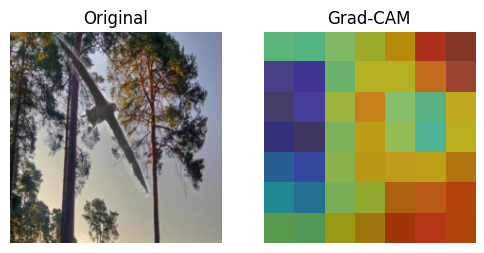

In [133]:
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam

baseline = get_model().to(device)  # load baseline
baseline.load_state_dict(torch.load('/content/baseline.pth'))
baseline.eval()


sample_img, target_label = None, None # Select a sample

with torch.no_grad():
    for x, y, _ in test_loader:          # _ = subgroup_id
        x = x.to(device); y = y.to(device)
        p = baseline(x).argmax(1)

        wrong_idx = (p != y).nonzero(as_tuple=True)[0]
        pick_idx  = wrong_idx[0] if wrong_idx.numel() else 0

        sample_img   = x[pick_idx].detach().cpu()
        target_label = y[pick_idx].item()
        break

layer_gc = LayerGradCam(baseline, baseline.layer4[-1])
attr     = layer_gc.attribute(sample_img.unsqueeze(0).to(device),
                              target=target_label)

heat = attr.squeeze().detach().cpu().numpy()
heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(sample_img.permute(1,2,0))        # CHW ➜ HWC
plt.axis('off'); plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(sample_img.permute(1,2,0)); plt.axis('off')
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.show()
